# Variogram and Spatial blocks

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip3 install pandas
  !pip3 install rasterio
  !pip3 install numpy
  !pip3 install geopandas
  !pip3 install gdal
  !pip3 install geostatspy
  !pip install shapely
  !pip install geopandas
  !pip3 install matplotlib-scalebar
  !pip install scikit-gstat
  !pip3 install fiona



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import geometry
from shapely.geometry import Point, Polygon
import fiona
import os
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

import skgstat as skg
import warnings
skg.plotting.backend('matplotlib')

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Thesis/data/'
base_dir = '/content/drive/MyDrive/Thesis/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Hessen_path = '/content/drive/MyDrive/Thesis/Base_shapefiles.gpkg'
data_path = '/content/drive/MyDrive/Thesis/data/'
raster_and_vector_data = os.path.join(data_path, 'raster_and_vector_data/')
Hessen = gpd.read_file(Hessen_path, layer='Hessen', driver="GPKG")
gpkg_path2 = '/content/drive/MyDrive/Thesis/Geology.gpkg'
print(f"Geology data: {fiona.listlayers(gpkg_path2)}")
#df = gpd.read_file(gpkg_path, layer='processed_data')

In [ ]:
# import custom scripts
import sys
sys.path.append(os.path.join(base_dir, 'scripts'))
import importlib

import Config
importlib.reload(Config)

from Config import (
    df_corr_columns_to_drop, df_corr_Geo_columns, seasonal_variables,
    columns_to_drop, feature_groups_list, rf_predictor_list, svr_predictor_list,
    gbr_predictor_list,rename_preds_dict, RenameUnit)


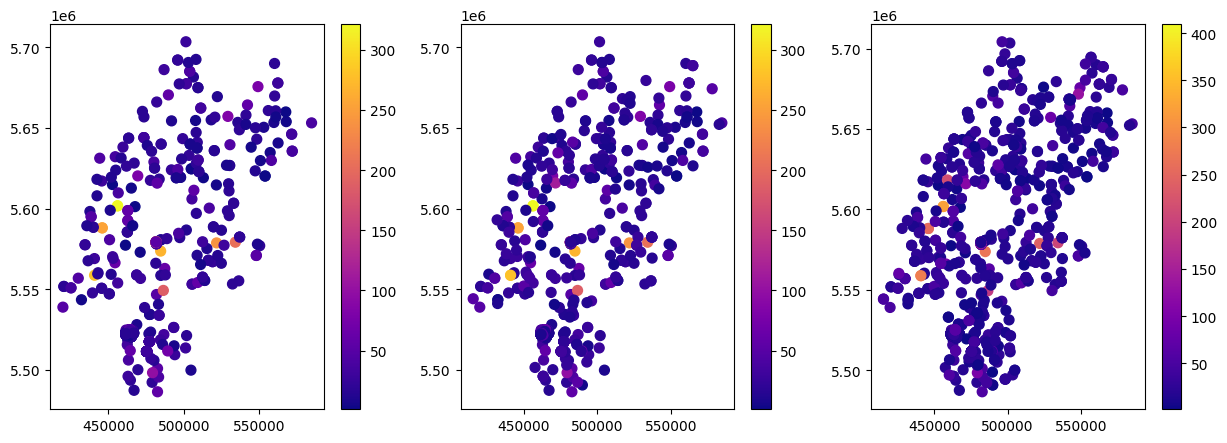

In [ ]:
df = gpd.read_file(gpkg_path2, layer='radon_and_uranium')

#for i in sampling_amount:
df1 = df.sample(n=600, replace=True, random_state=42, ignore_index=True)
df2 = df.sample(n=800, replace=True, random_state=42, ignore_index=True)
df3 = df.sample(n=1200, replace=True, random_state=42, ignore_index=True)

def plot_scatter(data, ax):
    art = ax.scatter(data.Eastings, data.Northings, 50, c=data.GRP, cmap='plasma')
    plt.colorbar(art, ax=ax)

# run
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for data, ax in zip((df1, df2, df3), axes.flatten()):
    plot_scatter(data, ax)

Variogram 1
RMSE Variogram 1: 622.2160816144954
----------------------------------------------------------------------------------------------------

Variogram 2


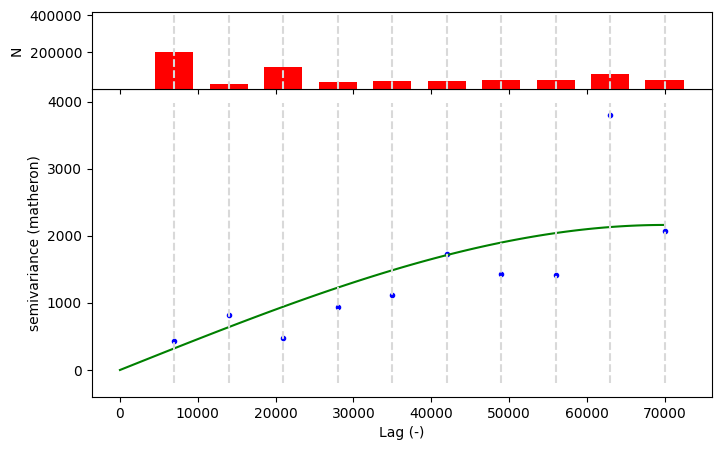

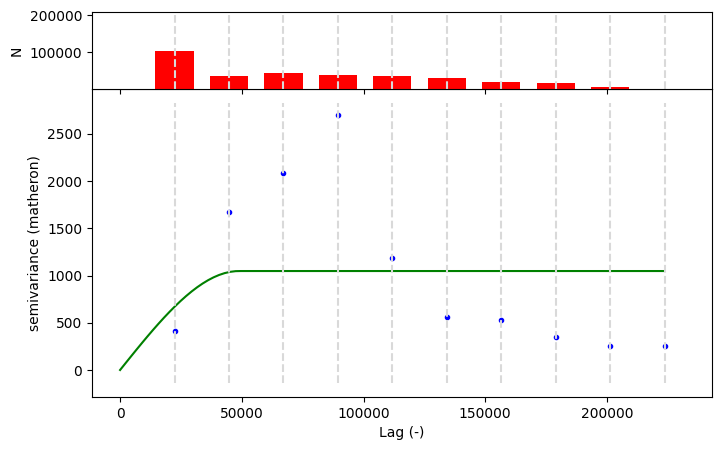

RMSE Variogram 2: 807.9495609768228
----------------------------------------------------------------------------------------------------

Variogram exponential


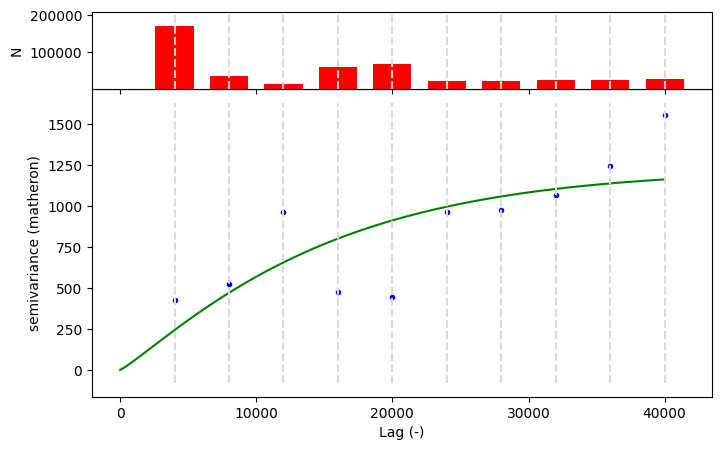

RMSE Variogram exponential: 251.6213096889938


In [ ]:
coords = list(zip(df.geometry.x, df.geometry.y))
values = df["GRP"]
coords_v2 = list(zip(df2.geometry.x, df2.geometry.y))
values_v2 = df2["GRP"]

print('Variogram 1')
V1 = skg.Variogram(df[['Eastings', 'Northings']].values, df.GRP.values, maxlag=70000, normalize=False)
V1.plot(show=False);
print(f'RMSE Variogram 1: {V1.rmse}')

print("-"*100)
print()

print('Variogram 2')
V_2 = skg.Variogram(coords_v2, values_v2)
V_2.plot()
plt.show()
print(f'RMSE Variogram 2: {V_2.rmse}')

print("-"*100)
print()

print('Variogram exponential')
Vexp = skg.Variogram(coords,values,model="stable",maxlag=40000,fit_range=10000,
                     fit_sill=300,fit_nugget=30)
# plot
Vexp.plot()
plt.show()
print(f'RMSE Variogram exponential: {Vexp.rmse}')

# Spatial blocks

In [ ]:
# https://stackoverflow.com/questions/31727333/get-the-name-of-a-pandas-dataframe
def find_df_name(df_name):
  name = [name for name,
          obj in globals().items(
          ) if id(obj) == id(df_name)]
  return name[0] if name else None

def get_fishnet(Geodataframe, square_size, clip_gdf=Hessen):
    # Read the shapefile
    gdf = Geodataframe
    #gpd.read_file('abbottstown_pa_union.shp')
    if gdf.crs != 'EPSG:25832':
        gdf = gdf.to_crs('EPSG:25832')
    total_bounds = gdf.total_bounds
    minX, minY, maxX, maxY = total_bounds

    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []

    # Polygon Size
    square_size = square_size
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon(
                [(x,y), (x, y+square_size),
                 (x+square_size, y+square_size),
                  (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size

    fishnet = gpd.GeoDataFrame(
        geom_array, columns=['geometry']
        ).set_crs('EPSG:25832')

    if clip_gdf is not None:
        if clip_gdf.crs != fishnet.crs:
            clip_gdf = clip_gdf.to_crs(fishnet.crs)
        fishnet = gpd.clip(fishnet, clip_gdf)

    return fishnet

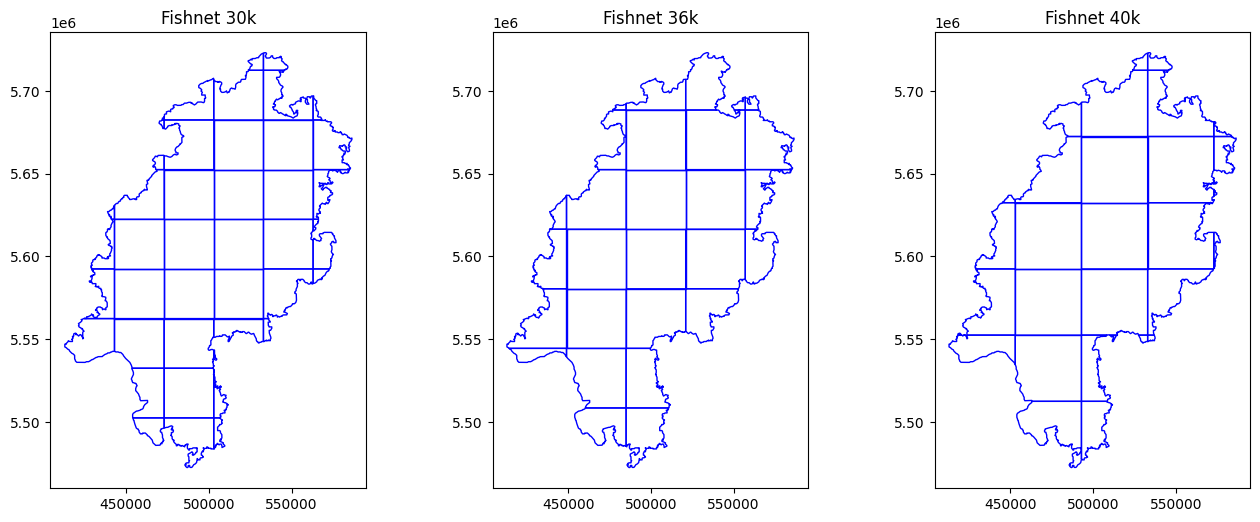

In [ ]:
sizes = [30000,36000,40000]
fishnets = {}
for size in sizes:
    fishnet = get_fishnet(Hessen, square_size=size)
    if not isinstance(fishnet, pd.DataFrame):
      fishnet = pd.DataFrame(fishnet)
    fishnets[size] = fishnet

#fishnets_data = [fishnets[30000], fishnets[36000], fishnets[40000]]
fishnets30k, fishnets36k, fishnets40k=fishnets[30000], fishnets[36000], fishnets[40000]
fishnets_data = [fishnets30k, fishnets36k, fishnets40k]

titles = ['Fishnet 30k', 'Fishnet 36k', 'Fishnet 40k']  # Replace with your desired titles

# helper function to plot grids
def plot_grids(df, ax, titles):
    fishnet.plot(
        ax=ax,
        edgecolor='blue',
        facecolor='none')
    ax.set_title(title, fontsize=12)

#plot grids as subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.4, hspace=0.3)

for fishnet, title, ax in zip(fishnets_data, titles, axes.flatten()):
    plot_grids(fishnet, ax, title)
plt.show()

In [ ]:
def short_cmap(df, column):
    vmin = df[column].min()
    vmax = df[column].max()
    # Create a colorbar with shortened limits
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label(column, rotation=270, labelpad=10)
    cbar.ax.tick_params(labelsize=10)
    return cbar

def plot_scatter(data, ax):
    art = ax.scatter(data.Eastings,
                     data.Northings,
                     20, c=data.GRP,
                     cmap='plasma')

    ax.set_title(find_df_name(data), fontsize=12)
    #plt.colorbar(art, ax=ax)
    #plt.axis('off')


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.4, hspace=0.3)

#for data, ax in zip(radon_dataframes, axes.flatten()):
#    plot_scatter(data, ax)
#    short_cmap(data, 'GRP')
#    plt.axis('off')


### Assign folds to grids

In [ ]:
def add_shuffled_column(gdf, column_name, seed=42):
    """
    Adds column with random numbers with specific range, shuffled and random seed
    """
    num_values = np.arange(1, 6)
    # Calculate the number of repetitions
    repetitions = (len(gdf) + len(num_values) - 1) // len(num_values)
    values = np.tile(num_values, repetitions)

    # Shuffle
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(values)
    values = np.resize(values, gdf.shape[0])

    # Add the new column to gdf
    gdf[column_name] = values.astype(str)
    gdf[column_name] = 'Fold_' + gdf[column_name].astype(str)

    return gdf

# Automate fishnet process
grids_columns = ['grids_30k', 'grids_36k', 'grids_40k']
grids_with_folds = []

for gdf, column_name in zip(fishnets_data, grids_columns):
      gdf = add_shuffled_column(gdf, column_name, seed=42)
      grids_with_folds.append(gdf)

grids_30k, grids_36k, grids_40k =grids_with_folds[0], grids_with_folds[1], grids_with_folds[2]
blocks=[grids_30k, grids_36k, grids_40k]
print(grids_36k.columns)

Index(['geometry', 'grids_36k'], dtype='object')


### Get folds

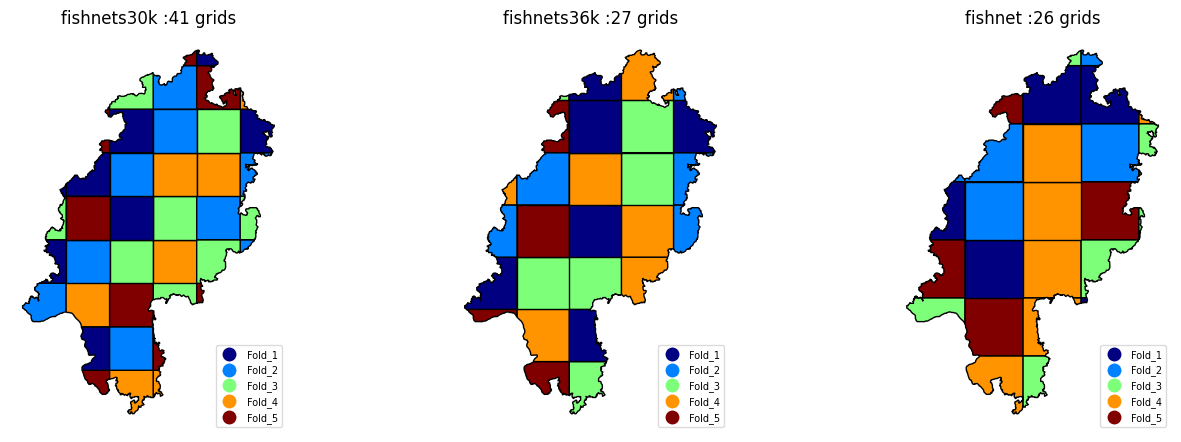

In [ ]:
def plot_fold(df,ax):
  df.plot(
      ax=ax, column=df.columns[1],
      cmap='jet',
      edgecolor='black', legend=True,
      legend_kwds={'loc': 4, 'framealpha': 0.7,
                   'fontsize': 7, 'title_fontsize': 8})

    # Customize plot appearance
  ax.set_axis_off()
  ax.set_title(find_df_name(df) + ' :' + str(
      df.shape[0]) + ' grids',fontsize=12)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.4, hspace=0.3)

for block, ax in zip(blocks, axes.flatten()):
  plot_fold(block, ax)
  #plt.show()

### Add folds to dataframe

In [ ]:
gpkg_path = '/content/drive/MyDrive/Thesis/Database.gpkg'
gpkg_path2 = '/content/drive/MyDrive/Thesis/Geology.gpkg'
GRP_Analysis_gpkg = '/content/drive/MyDrive/Thesis/GRP_Analysis.gpkg'
Database_gpkg = '/content/drive/MyDrive/Thesis/Database_gpkg.gpkg'

train_data = gpd.read_file(GRP_Analysis_gpkg, layer='train_data', driver='GPKG' )
test_data = gpd.read_file(GRP_Analysis_gpkg, layer='test_data', driver='GPKG' )
Final_model_data= gpd.read_file(GRP_Analysis_gpkg, layer='Final_model_data', driver='GPKG' )

radon_main = gpd.read_file(gpkg_path, layer='processed_data')
#radon_and_geo = gpd.read_file(gpkg_path2, layer='radon_and_uranium')



In [ ]:
def batch_join(point_gdf, list_of_polygon_gdfs):
  """
  Batch join several polygons to same shapefile.
  """
  # Iterate through the list of GeoDataFrames
  for idx, gdf in enumerate(list_of_polygon_gdfs):
      cols_to_remove=['index_left', 'index_right']
      # Perform spatial join
      if idx == 0:
          #new_gdf = gdf.copy()
          new_gdf = gpd.sjoin(
              point_gdf, gdf,
              how='inner', predicate='intersects')
      else:
          new_gdf.drop(
              columns=[col for col in cols_to_remove \
              if col in new_gdf.columns], inplace=True)
          new_gdf = gpd.sjoin(
              new_gdf, gdf, how='inner', predicate='intersects')
          new_gdf = new_gdf.loc[:,~new_gdf.columns.duplicated()]
          final_gdf = new_gdf.loc[:, ~new_gdf.columns.str.contains('index_left|index_right')]

  return final_gdf

In [ ]:
batch_join_train=batch_join(train_data, blocks)
batch_join_test=batch_join(test_data, blocks)
batch_join_Final=batch_join(Final_model_data, blocks)

print(train_data.shape[0] == batch_join_train.shape[0])
print(test_data.shape[0] == batch_join_test.shape[0])
print(Final_model_data.shape[0] == batch_join_Final.shape[0])

Model_data = '/content/drive/MyDrive/Thesis/Model_data.gpkg'

batch_join_block=batch_join(radon_main, blocks)
#print(batch_join_block.columns)

processor = RenameUnit(batch_join_block, 'hlnug')
batch_join_radon = processor.process_geology_columns()


True
True
True


Unique value counts for grids_30k:
grids_30k
Fold_1    700
Fold_2    369
Fold_3    197
Fold_4    154
Fold_5     89
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


Unique value counts for grids_36k:
grids_36k
Fold_4    913
Fold_3    257
Fold_1    158
Fold_2     92
Fold_5     89
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


Unique value counts for grids_40k:
grids_40k
Fold_5    776
Fold_4    347
Fold_1    196
Fold_2    136
Fold_3     54
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------




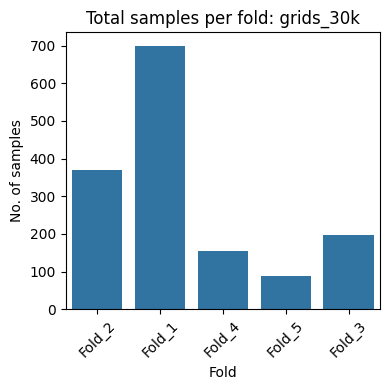

----------------------------------------------------------------------------------------------------


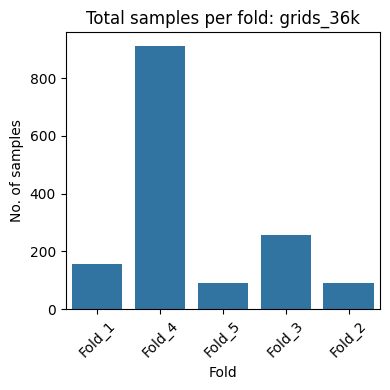

----------------------------------------------------------------------------------------------------


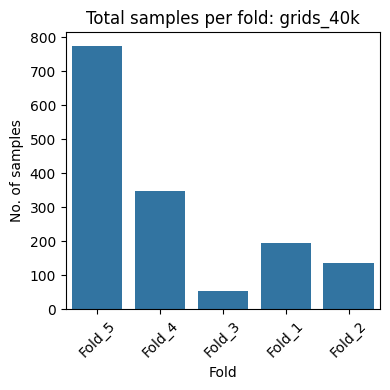

----------------------------------------------------------------------------------------------------


In [ ]:
for col in grids_columns:
    print(f"Unique value counts for {col}:")
    print(batch_join_block[col].value_counts())
    print("-"*100)
    print("\n")


print("-"*100)
print("\n")

for col in grids_columns:
    plt.figure(figsize=(4, 4))
    sns.countplot(x=batch_join_radon[col])
    plt.title(f'Total samples per fold: {col}')
    plt.xlabel('Fold')
    plt.ylabel('No. of samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.savefig(f'Total_samples_per_group_{col}.png', dpi='figure')  # Save each plot with a unique name
    plt.show()  # Display each plot
    print("-"*100)

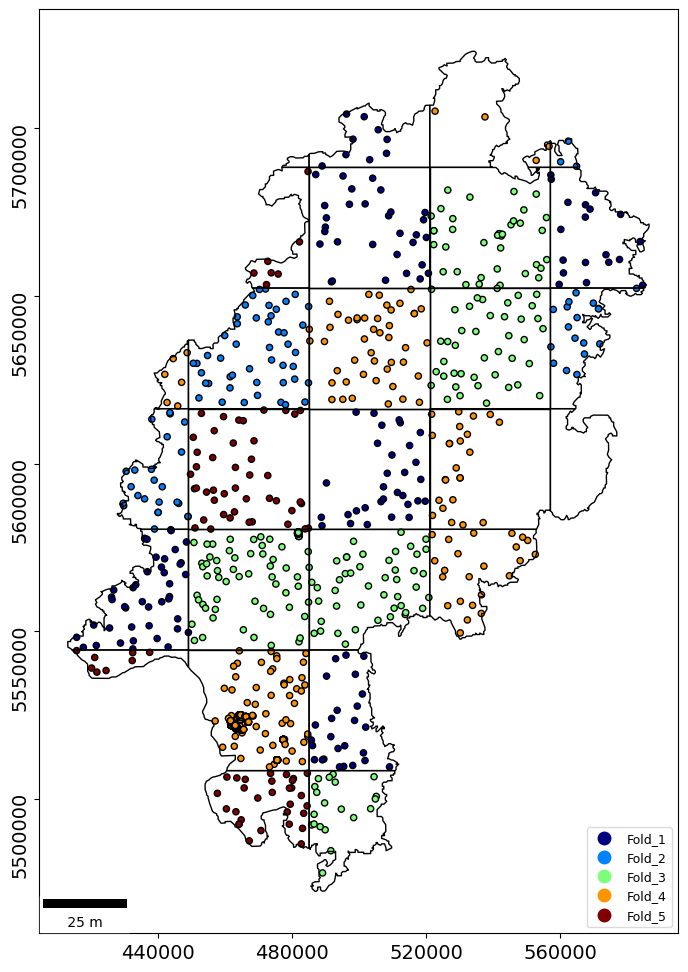

----------------------------------------------------------------------------------------------------



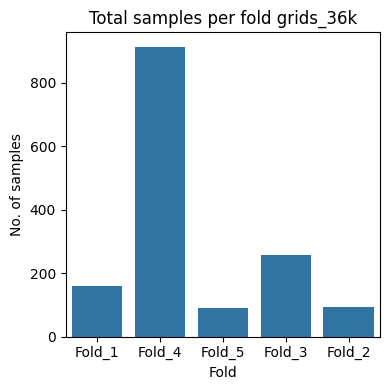

In [ ]:
#def plot_grids_and_points(pt_gdf, pol_gdf, pt_column, ax):

fig, ax=plt.subplots(figsize = (12,12))
ax1 = batch_join_block.plot(ax = ax, column = str('grids_36k'), cmap = 'jet',
            edgecolor='black', legend = True,markersize=20,
            legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':9,
                        'title_fontsize':9 })
ax2 = grids_36k.plot(ax=ax,column = grids_36k.columns[1], facecolor="none",
                  edgecolor='black')
plt.yticks(rotation=90)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(6))
ax.ticklabel_format(style='plain')
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
ax.add_artist(ScaleBar(
        dx=1, units="km", dimension="si-length", length_fraction=0.25,
        scale_formatter=lambda value, unit: f' {value * 1} m ',
        location='lower left'))

plt.show()
#fig.savefig('grid_ptsss.png', dpi=300)

print("-"*100)
print()

plt.figure(figsize=(4, 4))
sns.countplot(x=batch_join_radon['grids_36k'])
plt.title(f'Total samples per fold grids_36k')
plt.xlabel('Fold')
plt.ylabel('No. of samples')
#plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(f'Total_samples_per_group_{col}.png', dpi='figure')  # Save each plot with a unique name
plt.show()  # Display each plot
#print("-"*100)

                                   class_geo  count
0                 Holocene sedimentary rocks    599
1   Paleozoic Intermediate-felsic plutonites    113
2       Devonian to Carboniferous plutonites     54
3                  Triassic Bunter sandstone     50
4                      Pleistocene sediments     39
5                         Tertiary volcanics     25
6             Carboniferous felsic volcanics      7
7               Permian Rotliegend sediments      7
8                        Tertiary fluviatile      7
9                        Devonian fluviatile      4
10                      Triassic Muschelkalk      3
11                        Devonian volcanics      2
12                           Triassic Keuper      2
13                    Late Permian Zechstein      1
----------------------------------------------------------------------------------------------------



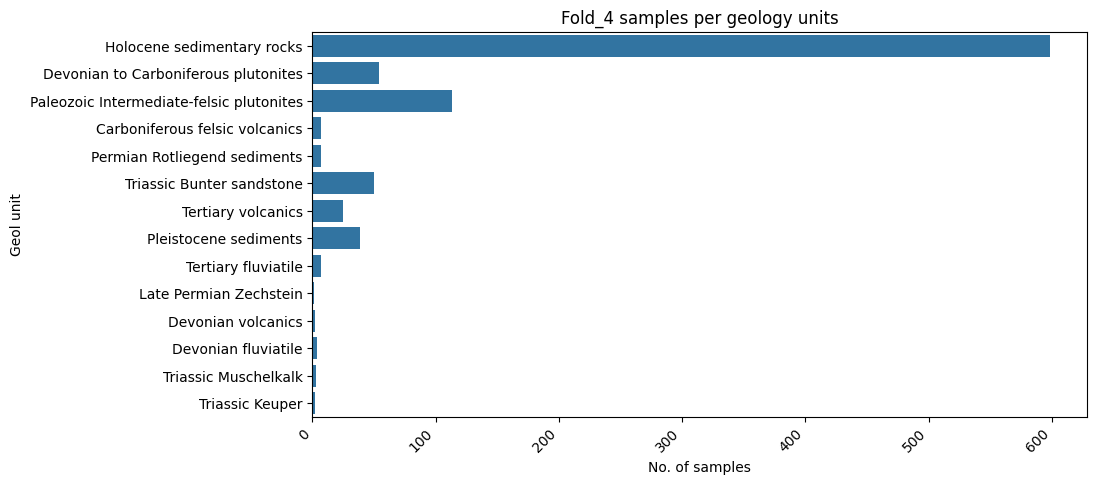

In [ ]:
# Fold 4 distribution per geol unit
def folds_and_geol_count(df, column, filter_value):
  folds_per_group = df[df[str(column)] == str(
        filter_value)]['class_geo'].value_counts().reset_index()
  return folds_per_group

## grids_36k fold 4
print(folds_and_geol_count(batch_join_radon, 'grids_36k', 'Fold_4'))

print("-"*100)
print()

plt.figure(figsize=(10, 5))
fold_4_vals = sns.countplot(
    batch_join_radon.loc[batch_join_radon['grids_36k'] == 'Fold_4']['class_geo'])

#gp3 = batch_join_block.loc[batch_join_block['grids_36k'] == 'Fold_1']

#rotate x-axis labels
fold_4_vals.set_xticklabels(fold_4_vals.get_xticklabels(), rotation=45,
                        horizontalalignment='right')
plt.title('Fold_4 samples per geology units')
plt.ylabel('Geol unit')
plt.xlabel('No. of samples')
plt.savefig('Total samples per strata.png', dpi='figure')

# Get validation data

(1208, 19)
(301, 19)


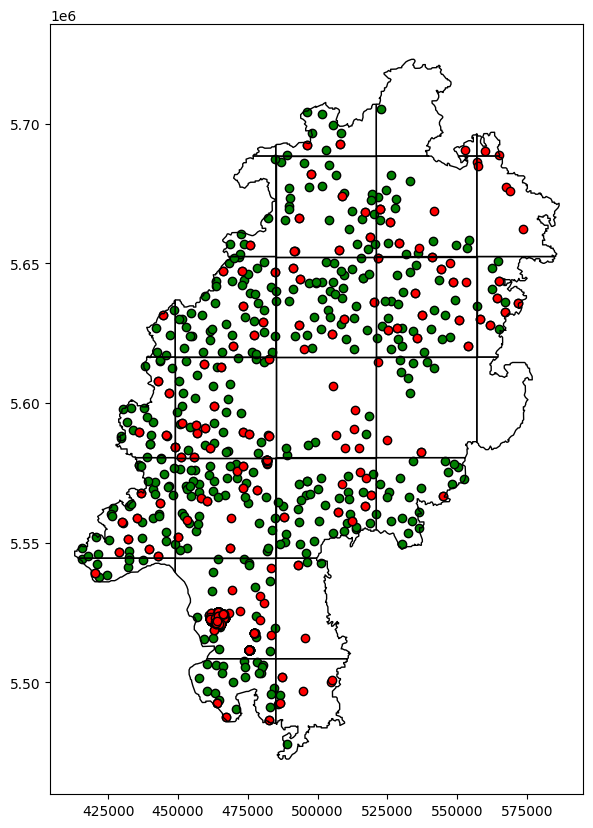

In [ ]:
## getting validation data main data

Validation_data = batch_join_block.groupby('class_geo').apply(
    lambda x: x.sample(
        frac=0.20, replace=False, random_state=42)).reset_index(drop=True)


Training_data = batch_join_block.drop(Validation_data.index)
Training_data.shape
print(Training_data.shape)
print(Validation_data.shape)

#Plot training and validation
fig, ax=plt.subplots(figsize = (10,10))
ax1 = Training_data.plot(ax = ax, column = 'GRP', color = 'green',
             figsize = (12,12),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':13,
                         'title_fontsize':13 })
ax1 = Validation_data.plot(ax = ax, column = 'GRP',color = 'red',
             figsize = (12,12),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':13,
                         'title_fontsize':13 })
ax2 = grids_36k.plot(ax=ax,column = 'grids_36k', facecolor="none",
                    figsize = (12,12), edgecolor='black')

### Save Training and validation data

In [ ]:
Training_data.to_file(gpkg_path, layer='Training_data', driver="GPKG")
Validation_data.to_file(gpkg_path, layer='Validation_data', driver="GPKG")